# Morphology Generation

In [1]:
# Imports, following example from Peter's coreshell tutorial (plus EulerMGs and NSFopen)
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys, pathlib, h5py
from skimage.filters import sobel_v, sobel_h, sobel, gaussian
import lib.checkh5 as chk
import lib.EulerMGs as EMG
from lib.util import write_euler_hdf5, write_config
from lib.reduce import read_img_h5, remesh  # Ignore WARNING: ... Unable to import pyOpenCL
from lib.generateConstants import write_materials
from NSFopen.read import read as afmreader

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# Import and binarize AFM images

In [4]:
# Specify working directory
notebookPath = pathlib.Path.cwd()
afmPath = notebookPath.joinpath('afm', '2022-2')

# Import AFM file locations as list
AFMs = sorted(list(afmPath.glob('*.nid')))
display(pd.Series([f.name for f in AFMs]))

0              A1.nid
1          A1_2um.nid
2          A2_2um.nid
3        A2_400nm.nid
4          A3_3um.nid
5    A3_450nm_r00.nid
6    A3_450nm_r90.nid
7              A5.nid
dtype: object

In [5]:
AFMs

[PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A1.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A1_2um.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A2_2um.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A2_400nm.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A3_3um.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A3_450nm_r00.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A3_450nm_r90.nid'),
 PosixPath('/Users/andrew/Library/CloudStorag

In [6]:
AFMs[0]

PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/analysis/cyrsoxs_work/afm/2022-2/A1.nid')

Reading Header
Reading Data
Elapsed Time: 0.11 sec

Reading Header
Reading Data
Elapsed Time: 0.03 sec



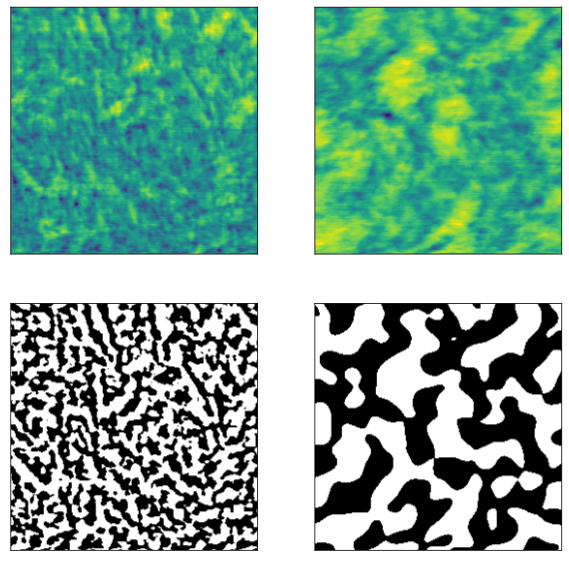

In [3]:
# Read AFM images
AFM_phase1 = afmreader(AFMs[0]).data['Image']['Forward']['Phase'].astype(float)
AFM_phase2 = afmreader(AFMs[7]).data['Image']['Forward']['Phase'].astype(float)

# Plotting and binarizing AFM images using EMG.process_image
fig, ax = plt.subplots(2, 2)
fig.set(size_inches=(10,10))
ax[0][0].imshow(AFM_phase1, origin='lower')
ax[0][1].imshow(AFM_phase2, origin='lower')
ax[1][0].imshow(EMG.process_image(AFM_phase1, block_size=7, filter_size=5)[0], origin='lower', cmap='gray')
ax[1][1].imshow(EMG.process_image(AFM_phase2, block_size=71, filter_size=7)[1], origin='lower', cmap='gray')

for i in (0,1):
    for j in (0,1):
        ax[i][j].axes.get_yaxis().set_visible(False)
        ax[i][j].axes.get_xaxis().set_visible(False)

plt.show()

In [21]:
binarized = AFM_phase1.copy()
binarized[binarized < binarized.mean()] = 0.
binarized[binarized > binarized.mean()] = 1.

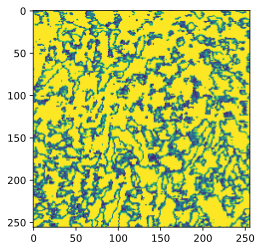

In [22]:
plt.imshow(binarized)

In [12]:
# Save binarized array(s) if satisfied with how they appear:
# Here I've chosen the AFM of my nexafs material, AFM1 (smaller domains)
AFM_binary = EMG.process_image(AFM_phase1, block_size=7, filter_size=5)[0]

In [13]:
AFM_binary.shape

(256, 256)

## Add orientation and mixing(?) at boundaries

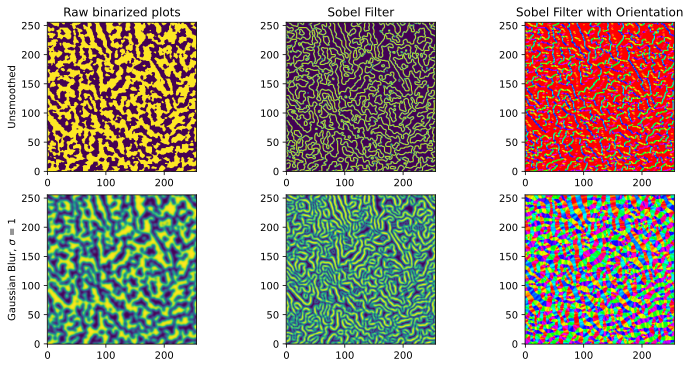

In [17]:
angles = np.arctan2(-sobel_h(AFM_binary),-sobel_v(AFM_binary))
angles_smoothed = np.arctan2(-sobel_h(gaussian(AFM_binary,sigma=1)),-sobel_v(gaussian(AFM_binary,sigma=1)))

# Plot/check it 
fig, ax = plt.subplots(2,3,dpi=140,figsize=(6,4),constrained_layout=True)
fig.set(size_inches=(10,5))
ax = ax.flatten()
ax[0].imshow(AFM_binary,origin='lower',interpolation='none')
ax[3].imshow(gaussian(AFM_binary, sigma=2),origin='lower',interpolation='none')
ax[1].imshow(sobel(AFM_binary),origin='lower',interpolation='none')
ax[4].imshow(sobel(gaussian(AFM_binary, sigma=2)),origin='lower',interpolation='none')
ax[2].imshow(angles,origin='lower',cmap='hsv',interpolation='none')
ax[5].imshow(angles_smoothed,origin='lower',cmap='hsv',interpolation='none')
ax[0].set_ylabel('Unsmoothed')
ax[3].set_ylabel(r'Gaussian Blur, $\sigma$ = 1')

ax[0].set_title('Raw binarized plots')
ax[1].set_title('Sobel Filter')
ax[2].set_title('Sobel Filter with Orientation')
plt.show()

In [8]:
# Define boundary of domains:
boundaries = sobel(gaussian(AFM_binary, sigma=0.3))>0

# Create Euler arrays
theta = np.zeros(AFM_binary.shape)
psi = theta.copy()

# Use Boolean indexing to only grab the orientation in the shell region
theta[boundaries] = np.pi/2
psi[boundaries] = angles_smoothed[boundaries]

# Bound orientation angles from 0 to pi for visualization, Cy-RSoXS woiuld accept any angle
psi = np.mod(psi,np.pi)

In [10]:
# Generate arrays for making .hdf5 cartoon file (needs Vfrac, order parameter (S), psi, and theta)
# Important: shape needs to be (1,dim,dim) and the dtype must be floats!
dim = AFM_binary.shape[0]  # Size of arrays

mat1_Vfrac = AFM_binary.copy().astype(float)  # Volume fraction of one domain material
mat1_Vfrac.shape = (1,dim,dim)
mat1_S = boundaries.copy().astype(float)  # alignment magnitude for polyethylene. Only the shell is aligned.
mat1_S.shape = (1,dim,dim)
mat1_psi = np.reshape(psi, (1,dim,dim))
mat1_theta = np.reshape(theta, (1,dim,dim))

mat2_Vfrac = np.ones(mat1_Vfrac.shape)
mat2_Vfrac -= mat1_Vfrac 
mat2_Vfrac.shape = (1,dim,dim)
mat2_S = mat1_S  
mat2_S.shape = (1,dim,dim)
mat2_theta = mat1_theta.copy()
mat2_psi = mat1_psi.copy()  # Assumes same in-plane alignment for both materials

# PhysSize = Voxel size, these AFM images are 500x500nm with 256x256 pixels
PhysSize = round((400/1024),2)

In [12]:
write_euler_hdf5([[mat1_Vfrac, mat1_S, mat1_theta, mat1_psi], [mat2_Vfrac, mat2_S, mat2_theta, mat2_psi]], PhysSize, 'BHJ.hdf5')

--> Marking BHJ.hdf5


'BHJ.hdf5'

Dataset dimensions: 1 × 1024 × 1024
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 1.0
Material 1 theta. Min: 0.0 Max: 1.5707963267948966
Material 1 psi. Min: 0.0 Max: 3.1415926535897927


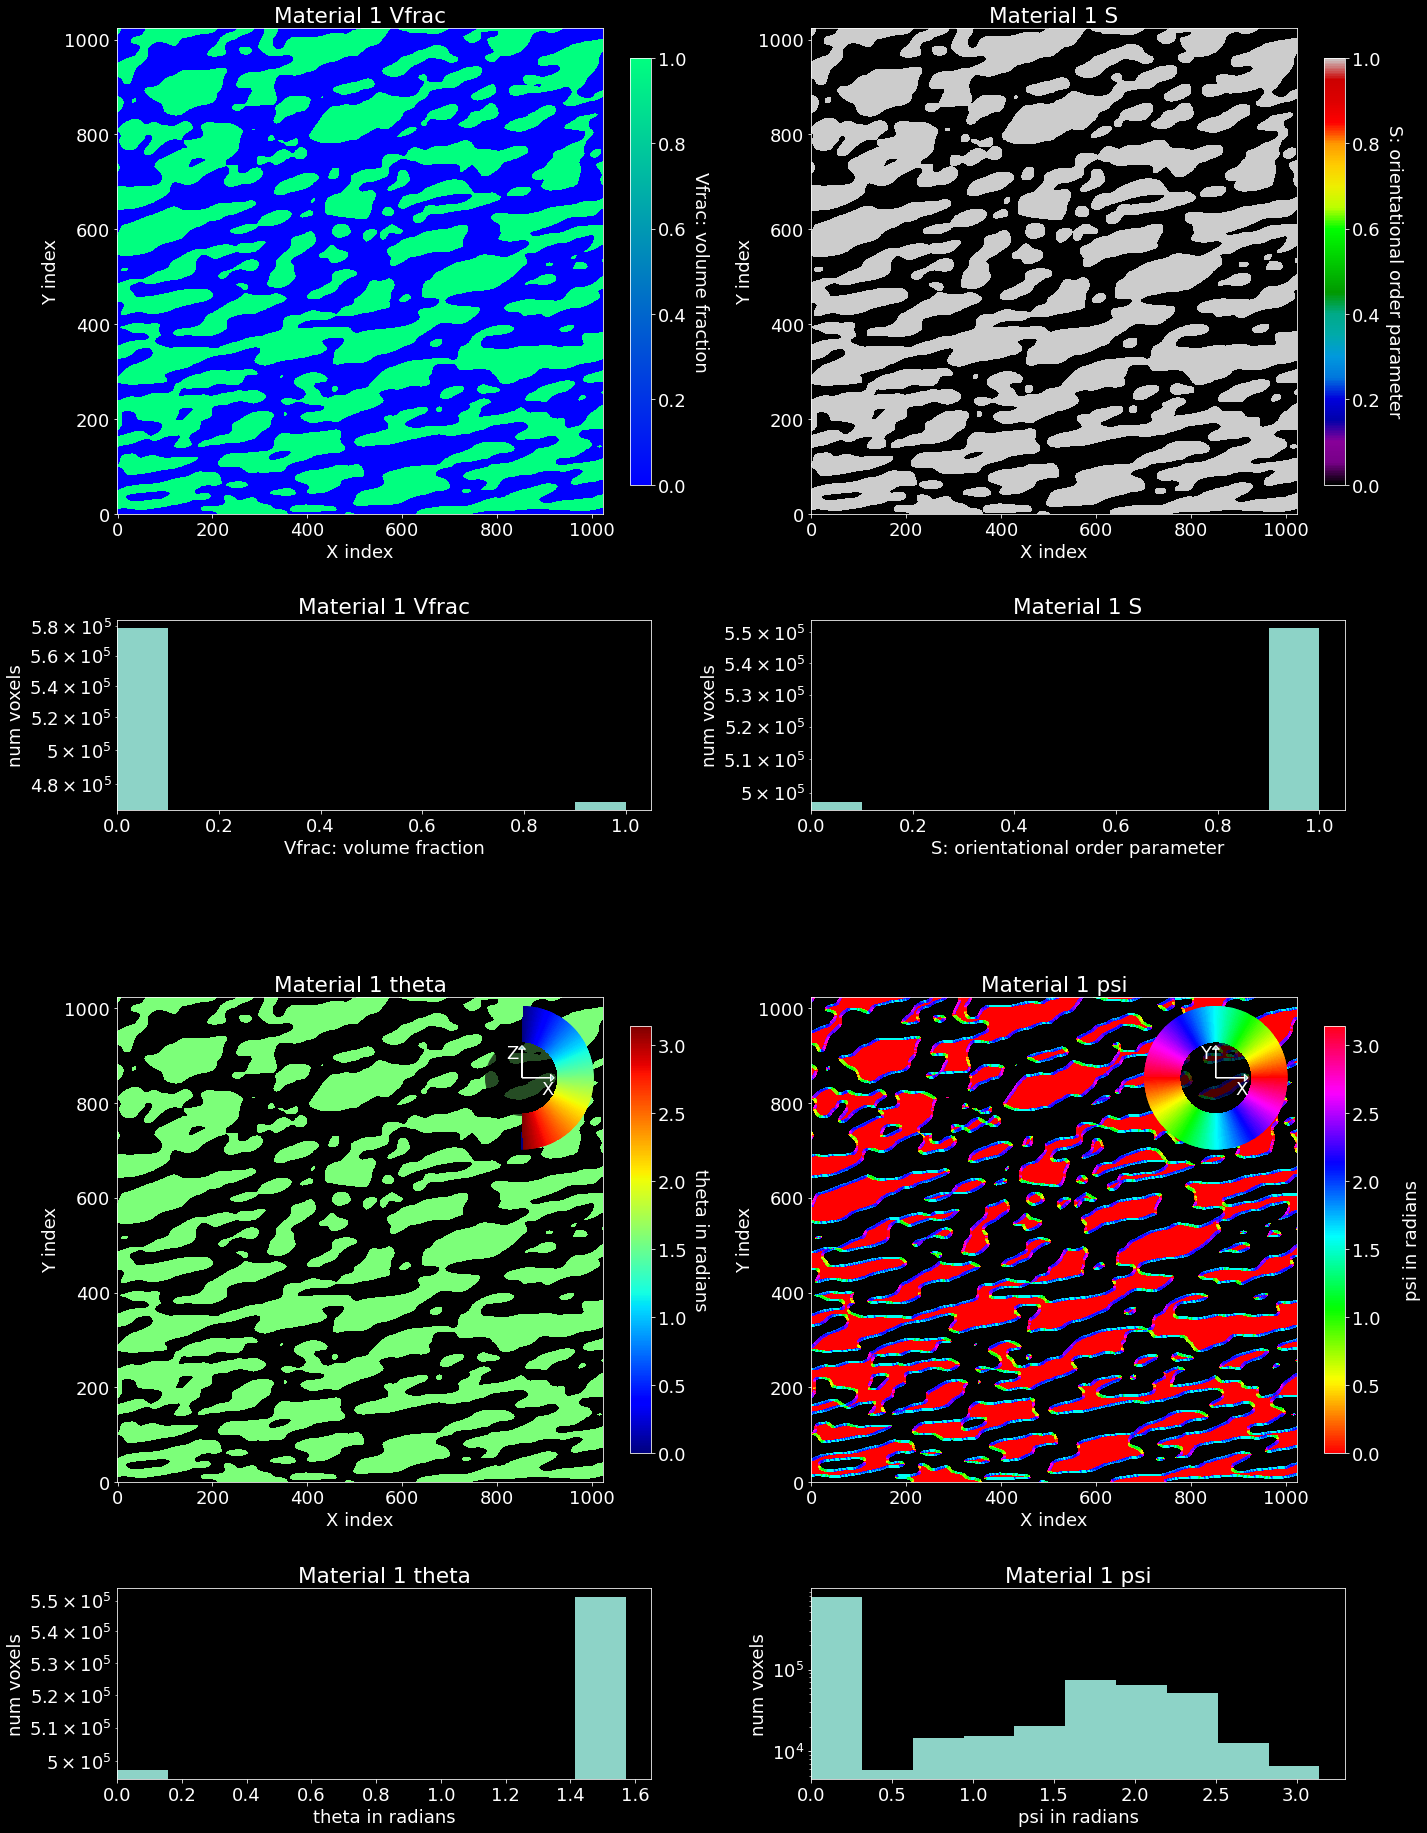

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 1.5707963267948966
Material 2 psi. Min: 0.0 Max: 3.1415926535897927


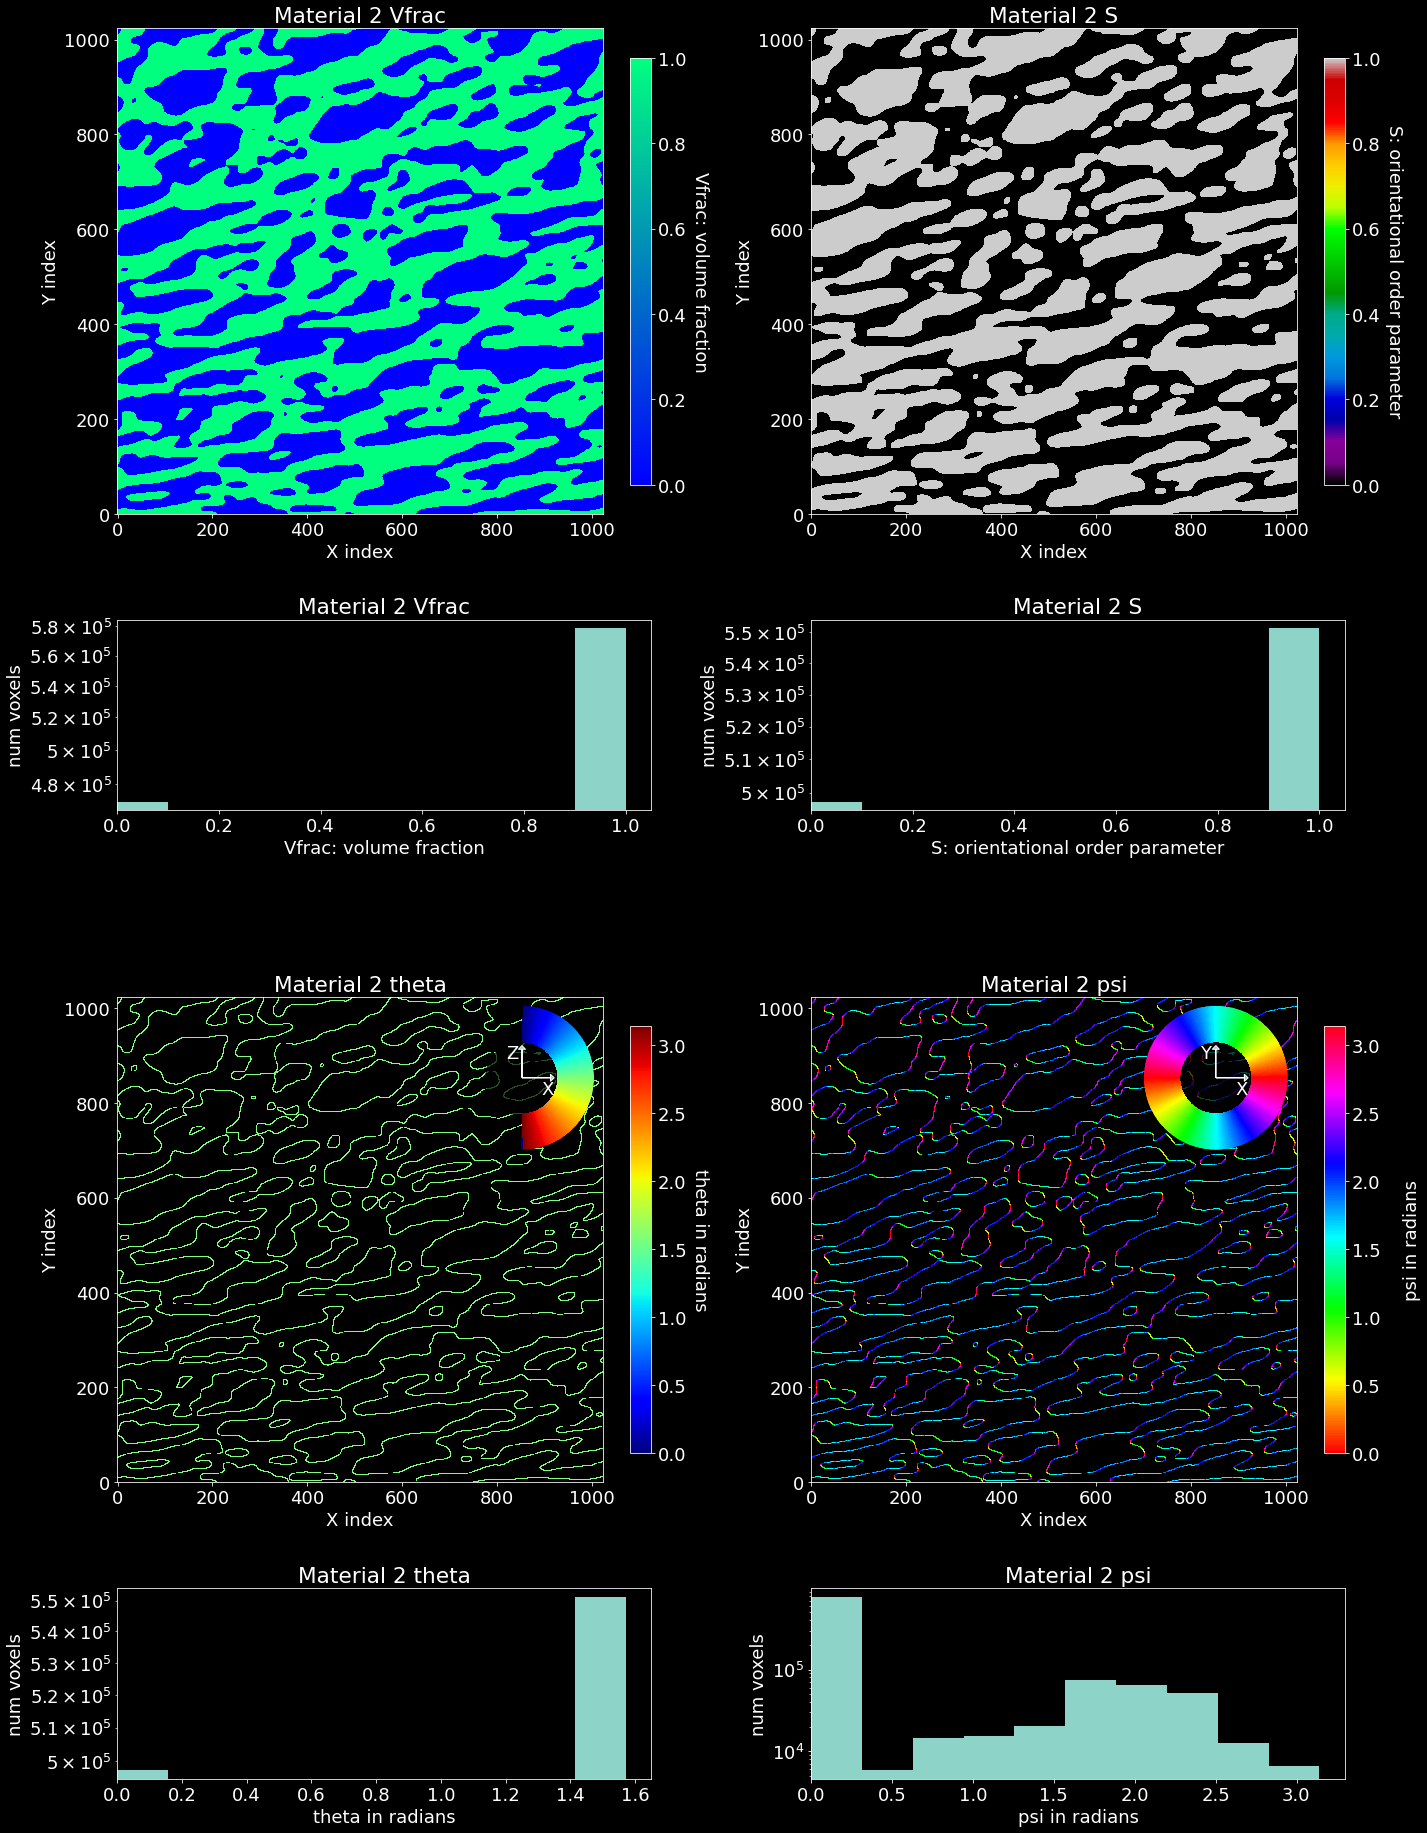

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:02.135947


In [13]:
set_matplotlib_formats('png')
chk.checkH5('BHJ.hdf5',z_slice=0,plotstyle='dark')

# Good initial morphology guess? 
#### Now generate the Material.txt files from the para and perp dielectric functions and to make the config.txt file to tell CyRSoXS what to simulate.

In [25]:
nexafsPath = notebookPath.joinpath('cyrsoxs_nexafs')

# Input paths to dielectric function files and put into dictionary for generating CyRSoXS-readable files
mat1_dielectric_file = list(nexafsPath.glob('nexafs2*'))[0]
mat2_dielectric_file = list(nexafsPath.glob('nexafs3*'))[0]
material_dict = {'Material1': mat1_dielectric_file,'Material2': mat2_dielectric_file} 

# Structure of material dielectric fxn files
energy_dict = {'Energy':0, 'DeltaPara':1, 'DeltaPerp':2, 'BetaPara':3, 'BetaPerp':4}

# List all energies you want to simulate:
energies = np.round(np.arange(275,300,0.1),1)

In [26]:
write_materials(energies, material_dict, energy_dict, 2)

#### The config.txt file contains information on which energies and angles to run, as well as the type of morphology (Euler or Vector).

In [33]:
np.arange(0,1e-2+1e-4,1e-4)

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055,
       0.0056, 0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063,
       0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071,
       0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079,
       0.008 , 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087,
       0.0088, 0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095,
       0.0096, 0.0097, 0.0098, 0.0099, 0.01  ])

In [34]:
# anlges = [start, increment, end] 
write_config(list(energies), [0.0, 1e-4, 1e-2], CaseType=0, MorphologyType=0)

## Now run CyRSoXS (submit slurm job)
1. Move materials, config, and .hdf5 files into CURC folder
2. Submit CyRSoXS job 

### Check output .h5 files in the generated HDF5 folder

In [ ]:
h5Path = pathlib.Path(workPath,'HDF5')
h5list = sorted(list(h5Path.glob('*h5')))

#### The scattering pattern at each energy is written to a separate HDF5 (.h5) file. We can look at the keys in the file

In [ ]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

The scattering pattern is contained within 'K0/projection.' If you simulated multiple incident angles there would be additional 'K#' keys. KIDList contains the vector values for each of the incident angles (propagation direction).

In [ ]:
# create numpy arrays to hold the scattering data
all_data = np.zeros((len(h5list),512,512))
# horizontal and vertical linecuts
horz = np.zeros((len(h5list),363))
vert = horz.copy()

# read in data, remesh, and take sector cuts
for i, file in enumerate(h5list):
    data = read_img_h5(file)
    remeshed_data = remesh(data)
    horz[i,:] = remeshed_data.sel(chi=slice(-10,10)).mean('chi')
    vert[i,:] = remeshed_data.sel(chi=slice(80,100)).mean('chi')
    all_data[i,:,:] = data.values

In [ ]:
# convert the numpy arrays into xarray dataframes for easier plotting/manipulation
horz_da = xr.DataArray(horz,dims=['energy','q'],coords={'energy':energies,'q':remeshed_data.q})
vert_da = xr.DataArray(vert,dims=['energy','q'],coords={'energy':energies,'q':remeshed_data.q})
all_data = xr.DataArray(all_data,dims=['energy','Qy','Qx'],coords={'energy':energies,'Qy':data.Qy, 'Qx':data.Qx})

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
all_data.sel(energy=275).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[0],add_colorbar=False)
all_data.sel(energy=284).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[1],add_colorbar=False)
all_data.sel(energy=287).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.4,0.4),axes.set_ylim(-0.4,0.4)} for axes in ax]
plt.show()

In [ ]:
# calculate the anisotropy metric
A = (vert_da - horz_da)/(vert_da + horz_da)

In [ ]:
A.plot(cmap='bwr',vmin=-1,vmax=1)
plt.xlim(1e-3)
plt.xscale('log')

In [ ]:
A.sel(energy=299,method='nearest').plot()

In [ ]:
vert_da.plot(cmap='terrain',norm=LogNorm(1e-6,1e2))
plt.xlim(1e-3)
plt.xscale('log')

In [ ]:
horz_da.plot(cmap='terrain',norm=LogNorm(1e-6,1e2))
plt.xlim(1e-3)
plt.xscale('log')

In [ ]:
horz_da.sel(energy=275).plot(yscale='log',xscale='log')

In [ ]:
horz_da.sel(energy=275).plot(xscale='log',yscale='log',label='275 eV Horizontal',color='tab:blue')
vert_da.sel(energy=275).plot(xscale='log',yscale='log',label='275 eV Vertical',linestyle='--',color='tab:blue')
horz_da.sel(energy=284,method='nearest').plot(xscale='log',yscale='log',label='284 eV Horizontal',color='tab:orange')
vert_da.sel(energy=284).plot(xscale='log',yscale='log',label='275 eV Vertical',linestyle='--',color='tab:orange')
horz_da.sel(energy=287,method='nearest').plot(xscale='log',yscale='log',label='287 eV Horizontal',color='tab:green')
vert_da.sel(energy=287).plot(xscale='log',yscale='log',label='275 eV Vertical',linestyle='--',color='tab:green')
plt.legend()
plt.xlabel(r'q [nm$^{-1}$]')
plt.ylabel('I(q)')
plt.show()

#### If you want to look at the dielectric functions in the Material#.txt files

In [ ]:
def read_material(filename):
    with open(filename,'r') as f:
        lines = f.readlines()
    Energy = []
    betapara = []
    betaperp = []
    deltapara = []
    deltaperp = []
    for line in lines:
        if line.startswith('Energy '):
            split_line = line.split(' = ')
            Energy.append(float(split_line[1].strip(';\n')))
        elif line.startswith('BetaPara'):
            split_line = line.split(' = ')
            betapara.append(float(split_line[1].strip(';\n')))
        elif line.startswith('BetaPerp'):
            split_line = line.split(' = ')
            betaperp.append(float(split_line[1].strip(';\n')))
        elif line.startswith('DeltaPara'):
            split_line = line.split(' = ')
            deltapara.append(float(split_line[1].strip(';\n')))
        elif line.startswith('DeltaPerp'):
            split_line = line.split(' = ')
            deltaperp.append(float(split_line[1].strip(';\n')))
    para = [complex(delta, beta) for delta, beta in zip(deltapara, betapara)]
    perp = [complex(delta, beta) for delta, beta in zip(deltaperp, betaperp)]
    return np.array(Energy), np.array(para), np.array(perp)

In [ ]:
energy, para, perp = read_material('Material1.txt')

In [ ]:
plt.plot(energy,para.real,'.')
plt.ylim(-0.0015,0.0025)

#### Compare to the original file to make sure we've written each Material#.txt file correctly

In [ ]:
Data = np.loadtxt('PEOlig2018.txt',skiprows=1);
Data = Data[Data[:,energy_dict["Energy"]].argsort()]

In [ ]:
plt.figure(dpi=140)
plt.plot(Data[:,6],Data[:,2])
plt.plot(energy,para.real)
plt.ylim(-0.0015,0.0025)
plt.xlim(270,300)